<a href="https://colab.research.google.com/github/MartC53/599Data/blob/main/RPA_Spot_Counter_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RPA Spot detection 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from ipywidgets import interact
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from scipy import stats
from google.colab import drive

#Mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Functions

In [ ]:
def ImportTifData(path):
    """Imports the example data set array as tiff files and returns as a 
  numpy array and the dimensions of the array.
  Extended Summary:
  -----------------

  This function takes an array that contains the paths of the example data set
  and returns the tiff data as an array. This requires access to the "Data for 
  Sharing" folder in google drive. The array contains the path of all the images
  of interest for a demo of the algorithm. It also return the number of images 
  in the tif stack, lenght of image, and width of image.

  String contains index of images[25cp, 50cp, 100cp, 500cp, 1000cp, 10000cp]
  
  Parameters:
  -----------
  Path: str()
              sting containing the path of the images
  Returns:
  --------
    Returns: np.array (tiff image data as a 3D numpy array)
    Returns: np.array ([n_images, length, width])
  Example:
  --------
  >>>ImportTifData(DataPath)
  """
    Data = io.imread(path)
    [n_images, length, width] = np.shape(Data)
    return Data

In [ ]:
def backgroundSub(Data):
  """Remove the background utilizng the average of 240 frames  
  Extended Summary: 
  -----------------
  This funciton will take the first 240 frames, average the data, then subtract
  it from the entire data set creating a backgorund removal dataset. 

  Parameters:
  -----------
  Data: numpy.ndarray
        [number of images, number of pixel rows, number of pixel columns]

  Returns:
  --------
    Data_adj: numpy.ndarray
        [number of images, number of pixel rows, number of pixel columns] 

  Example:
  --------
  >>>background(Data)
  
  """
  import numpy as np
  [n_images, length, width] = np.shape(Data)

#Define background array 
  background = np.zeros((length, width))
  n_bg = 240 #240 frames is the desired number of frames to average

#Average the entire background data Frame 1-240
  for i in range (0, n_bg):
    background = background + Data[i,:,:]
  background = background / n_bg

#Subtract the background from entire dataset 
  Data_adj = np.zeros((n_images, length, width))
  for i in range (0, n_images-1):
    Data_adj[i,:,:] = Data[i,:,:] - background
  Data_adj[Data_adj < 0] = 0
  return Data_adj

In [ ]:
def spot_display(Data_gauss):
  """Show every tenth frame of the dataset with locations of spots detected

  Extended Summary:
  -----------------
  This function displays an image stack with a slider to move between every 
  tenth frame. Locations of spots detected in each frame are shown as red dots.

  Parameters:
  -----------
  Data_gauss: numpy.ndarray
              [number of images, number of pixels rows, number of pixel columns]
  
  Returns:
  --------
  Interactive graph object with slider between frames, locations of detected 
  spots as red dots.

  Example:
  --------
  >>>spot_detection(Data_gauss)

  """
  #define spot detector parameters
  min_distance = 4
  threshold_rel = 0.25

  #number of images to iterate over
  n_images = np.shape(Data_gauss)[0]

  def slider(i):
    plt.imshow(Data_gauss[i,:,:], cmap='gray')
    plt.plot(peak_local_max(Data_gauss[i,:,:], min_distance, threshold_rel = threshold_rel)[:,1], peak_local_max(Data_gauss[i,:,:], min_distance, threshold_rel = threshold_rel)[:,0], 'r.')
    plt.axis('off')
  inc=10
  interact(slider, i=(0, n_images-1, inc))

In [ ]:
def spot_result(Data_gauss):
  """Counts the number of amplification spots in an RPA dataset and returns the 
    initial number of DNA copies amplified
  
  Extended Summary:
  -----------------
  This function takes an RPA image stack as an input and returns the number of 
  amplification spots. Accuracy requires the image stack input has been 
  previously processed with background subtraction and gaussian filter 
  functions. The number of amplification spots is compared against a standard 
  curve and the number of initial DNA copies is also returned. Datasets with 
  average final frame intensities greater than 350 are not counted as they are
  subject to inaccurate results.
  
  Parameters:
  -----------
  Data_gauss: numpy.ndarray
              [number of images, number of pixels rows, number of pixel columns]

  Returns:
  --------
  if average final frame intensity > 350: 
    Returns: 'Final frame intensity too high, initial DNA count outside of range of 
            standard curve (25-1000 copies). Repeat RPA at a higher dilution'

  if average final frame intensity < 350 and calculated spot count > 30.249:
    Returns: Spot count, 
             'Spot count outside range of standard curve (25-1000 copies), repeat 
             RPA at a higher dilution.',
             Plot of the standard curve and the spot count result

  if average final frame intensity < 350 and calculated spot count < 30.249:
    Returns: Spot count,
             log (Initial DNA copies) calculated from standard curve,
             Initial number of DNA copies,
             Plot of the standard curve and the spot count result

  Example:
  --------
  >>>spot_result(Data_gauss)

  """
  #define spot detector parameters
  min_distance = 4
  threshold_rel = 0.25

  #number of images to iterate over
  n_images = np.shape(Data_gauss)[0]

  #initialize spot counter
  n_spots = np.zeros(n_images)

  #intensity of last frame
  final_frame_intensity = np.average(Data_gauss[n_images-1,:,:])

  #spot counter
  for i in range (0, n_images-1):
    im = Data_gauss[i,:,:]
    maxima = peak_local_max(im, min_distance, threshold_rel = threshold_rel)
    n_maxima = np.shape(maxima)[0]
    n_spots[i] = n_maxima
  spot_count = np.average(n_spots[n_images-102:n_images-2])

  #standard curve
  cDNA = [25, 50, 100, 500, 1000]
  logcDNA = np.log10(cDNA)
  avg = [2, 2.01, 6.48, 25.09, 31.33]
  stdev = [0, 1.72, 2.18, 10.76, 0.25]
  slope, intercept, r_value, p_value, std_err = stats.linregress(logcDNA, avg)
  standard_curve = slope*logcDNA + intercept

  max_spot_count = slope*3.0 + intercept

  #initial DNA calculations from standard curve
  log_initialcDNA = (spot_count - intercept)/slope
  n_initial_DNA = round(10**log_initialcDNA)
  
  if final_frame_intensity > 350:
    print('Final frame intensity too high, initial DNA count outside of range of standard curve (25-1000 copies). Repeat RPA at a higher dilution')
  else:
    if spot_count > max_spot_count:
      print('Spot count:', round(spot_count))
      print('Spot count outside range of standard curve, repeat RPA at a higher dilution.')
      plt.plot(logcDNA, standard_curve, label='Standard Curve', color='b')
      plt.plot(logcDNA, avg, 'o',label='RPA standards', color='b')
      plt.errorbar(logcDNA, avg, stdev, marker='o', capsize=5, fmt='none', ecolor='b')
      plt.plot(log_initialcDNA, spot_count, marker='o', color = 'r', label='RPA spot count')
      plt.xlabel('log (Initial DNA Copies)')
      plt.ylabel('RPA Spot Count')
      plt.title('RPA Standard Curve: cDNA')
      plt.legend()
    else:
      print('Spot count:', round(spot_count))
      print('log (Initial DNA copies):', round(log_initialcDNA,2))
      print('Initial number of DNA copies:', n_initial_DNA)
      plt.plot(logcDNA, standard_curve, label='Standard Curve', color='b')
      plt.plot(logcDNA, avg, 'o',label='RPA standards', color='b')
      plt.errorbar(logcDNA, avg, stdev, marker='o', capsize=5, fmt='none', ecolor='b')
      plt.plot(log_initialcDNA, spot_count, marker='o', color = 'r', label='RPA spot count')
      plt.xlabel('log ( Initial DNA Copies )')
      plt.ylabel('RPA Spot Count')
      plt.title('RPA Standard Curve: cDNA')
      plt.legend()

Workflow

In [ ]:
DataPath=[
    '/content/drive/MyDrive/RPA-Spot-Detection/DATA_For_Sharing/example 1- 25cp.tif',
    '/content/drive/MyDrive/RPA-Spot-Detection/DATA_For_Sharing/example 2- 50cp.tif','/content/drive/MyDrive/RPA-Spot-Detection/DATA_For_Sharing/example 3- 100cp.tif',
    '/content/drive/MyDrive/RPA-Spot-Detection/DATA_For_Sharing/example 4- 500cp.tif','/content/drive/MyDrive/RPA-Spot-Detection/DATA_For_Sharing/example 5- 1000cp.tif',
    '/content/drive/MyDrive/RPA-Spot-Detection/DATA_For_Sharing/example 6- 10000cp.tif'
]

In [ ]:
Data = ImportTifData(DataPath[2]) #Change index to view other datasets range 0-5


In [ ]:
Data_adj = backgroundSub(Data) #Background Subtraction

In [ ]:
Data_gauss = gaussian(Data_adj,1.3) #Gaussian Filter

In [ ]:
spot_display(Data_gauss) #Spot Display with local maximum overlay and slider between frames

interactive(children=(IntSlider(value=590, description='i', max=1199, step=10), Output()), _dom_classes=('widg…

Spot count: 4
log (Initial DNA copies): 1.7
Initial number of DNA copies: 51


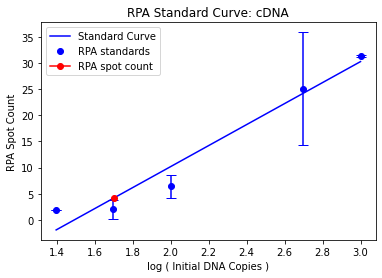

In [ ]:
spot_result(Data_gauss) #Spot counting result, comparison with standard curve.